## LSTM Time Series Model

In [100]:
# imports
import pandas as pd
from pathlib import Path
import datetime
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import RobustScaler
tf.random.set_seed(99)

In [101]:
# read in merged csv 
df = pd.read_csv(Path("Resources/weather_energy_merged.csv", index=False))
df.head()

,state,st_abb,date,tmin (f),tmax (f),tavg (f),ppt,coal (kt),natural gas (kMcf),petroleum coke (kt),petroleum liquids (kb)
0,Alabama,AL,2001-01-01,29.1524,51.8234,40.4870,119.501,3076,7802,0,340
1,Arkansas,AR,2001-01-01,26.6612,45.7412,36.2012,88.598,1320,2885,0,222
2,Arizona,AZ,2001-01-01,28.2722,51.9206,40.0964,41.955,1773,7222,0,268
3,California,CA,2001-01-01,31.7372,52.7198,42.2276,87.828,154,106635,94,625
4,Colorado,CO,2001-01-01,11.2748,37.4252,24.3500,25.485,1777,6538,0,52


## Data Preprocessing

In [102]:
# convert 'date' to datetime format and set to index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df['month'] = df.index.month
df['year'] = df.index.year

df.head()

,state,st_abb,tmin (f),tmax (f),tavg (f),ppt,coal (kt),natural gas (kMcf),petroleum coke (kt),petroleum liquids (kb),month,year
date,,,,,,,,,,,,
2001-01-01,Alabama,AL,29.1524,51.8234,40.4870,119.501,3076,7802,0,340,1,2001
2001-01-01,Arkansas,AR,26.6612,45.7412,36.2012,88.598,1320,2885,0,222,1,2001
2001-01-01,Arizona,AZ,28.2722,51.9206,40.0964,41.955,1773,7222,0,268,1,2001
2001-01-01,California,CA,31.7372,52.7198,42.2276,87.828,154,106635,94,625,1,2001
2001-01-01,Colorado,CO,11.2748,37.4252,24.3500,25.485,1777,6538,0,52,1,2001


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13248 entries, 2001-01-01 to 2023-12-01
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   13248 non-null  object 
 1   st_abb                  13248 non-null  object 
 2   tmin (f)                13248 non-null  float64
 3   tmax (f)                13248 non-null  float64
 4   tavg (f)                13248 non-null  float64
 5   ppt                     13248 non-null  float64
 6   coal (kt)               13248 non-null  object 
 7   natural gas (kMcf)      13248 non-null  object 
 8   petroleum coke (kt)     13248 non-null  object 
 9   petroleum liquids (kb)  13248 non-null  object 
 10  month                   13248 non-null  int32  
 11  year                    13248 non-null  int32  
dtypes: float64(4), int32(2), object(6)
memory usage: 1.2+ MB


In [104]:
# filter to chosen state
df = df[df['state'] == 'Texas']

In [105]:
# convert energy types to numeric
df['coal (kt)'] = pd.to_numeric(df['coal (kt)'], errors='coerce')
df['natural gas (kMcf)'] = pd.to_numeric(df['natural gas (kMcf)'], errors='coerce')
df['petroleum coke (kt)'] = pd.to_numeric(df['petroleum coke (kt)'], errors='coerce')
df['petroleum liquids (kb)'] = pd.to_numeric(df['petroleum liquids (kb)'], errors='coerce')


In [106]:
df.head()

,state,st_abb,tmin (f),tmax (f),tavg (f),ppt,coal (kt),natural gas (kMcf),petroleum coke (kt),petroleum liquids (kb),month,year
date,,,,,,,,,,,,
2001-01-01,Texas,TX,32.5508,53.7674,43.1600,58.369,8003,147020,52.0,2584.0,1,2001
2001-02-01,Texas,TX,39.1658,62.9168,51.0404,50.657,7221,126393,46.0,486.0,2,2001
2001-03-01,Texas,TX,41.4464,63.2606,52.3526,80.271,7610,144804,63.0,258.0,3,2001
2001-04-01,Texas,TX,54.9140,79.4192,67.1666,18.715,6900,155113,47.0,140.0,4,2001
2001-05-01,Texas,TX,61.4606,86.2250,73.8428,72.098,8164,174143,58.0,66.0,5,2001


In [107]:
# extract relevant columns
df_selected = df[['tmin (f)', 'tmax (f)', 'tavg (f)', 'coal (kt)', 'month', 'year']]

# drop rows with missing values
df_selected = df_selected.dropna()

df_selected.head()

,tmin (f),tmax (f),tavg (f),coal (kt),month,year
date,,,,,,
2001-01-01,32.5508,53.7674,43.1600,8003,1,2001
2001-02-01,39.1658,62.9168,51.0404,7221,2,2001
2001-03-01,41.4464,63.2606,52.3526,7610,3,2001
2001-04-01,54.9140,79.4192,67.1666,6900,4,2001
2001-05-01,61.4606,86.2250,73.8428,8164,5,2001


## Model Preparation

In [145]:
# Cyclical features for months
df_selected['month_sin'] = np.sin(2 * np.pi * df_selected['month'] / 12)
df_selected['month_cos'] = np.cos(2 * np.pi * df_selected['month'] / 12)

df_selected.head()

,tmin (f),tmax (f),tavg (f),coal (kt),month,year,month_sin,month_cos
date,,,,,,,,
2001-01-01,32.5508,53.7674,43.1600,8003,1,2001,0.500000,8.660254e-01
2001-02-01,39.1658,62.9168,51.0404,7221,2,2001,0.866025,5.000000e-01
2001-03-01,41.4464,63.2606,52.3526,7610,3,2001,1.000000,6.123234e-17
2001-04-01,54.9140,79.4192,67.1666,6900,4,2001,0.866025,-5.000000e-01
2001-05-01,61.4606,86.2250,73.8428,8164,5,2001,0.500000,-8.660254e-01


In [146]:
# scale the features using MinMaxScaler
features = ['tmin (f)', 'tmax (f)', 'tavg (f)', 'year']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_selected[features])

In [147]:
# create a separate scaler for coal (target)
energy_scaler = MinMaxScaler()
scaled_total_energy = energy_scaler.fit_transform(df_selected['coal (kt)'].values.reshape(-1, 1))


In [148]:
# convert data into sequences for time-series model
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

## Model Building, Running, Predictions, and Evaluation

### Model #1
- Hyperparameters:
    - sequence length: 15
    - 2 layers
    - 50 units for first two layers
    - 50 epochs

In [160]:
# prepare the feature and target data
X, y = create_sequences(scaled_features, scaled_total_energy.flatten(), seq_length=15)

In [161]:
# split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [162]:
# build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

c:\Users\Chris\anaconda3\envs\dev\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [163]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [164]:
# train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.3009 - val_loss: 0.3778
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0636 - val_loss: 0.3203
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0412 - val_loss: 0.1052
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0413 - val_loss: 0.1375
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0303 - val_loss: 0.1474
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0293 - val_loss: 0.0753
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0283 - val_loss: 0.0786
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0262 - val_loss: 0.0764
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0252 - val_loss: 0.0647
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0242 - val_loss: 0.0731
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0228 - val_loss: 0.0624
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0216 - val_loss: 0.0577


In [165]:
# evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0131 
Test Loss: 0.012070530094206333


In [166]:
# make predictions
y_pred_scaled  = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step


In [167]:
# inverse scaling for predictions
y_pred = energy_scaler.inverse_transform(y_pred_scaled)
# inverse scaling for the actual values
y_test_actual = energy_scaler.inverse_transform(y_test.reshape(-1, 1))

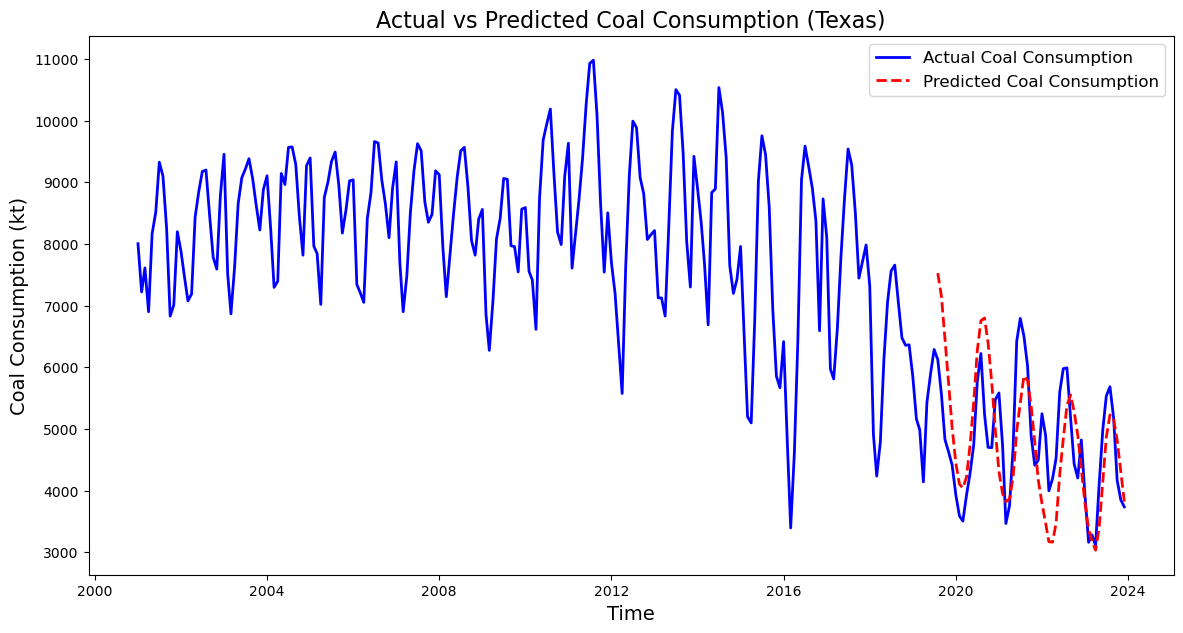

In [168]:
# plot the results
plt.figure(figsize=(14, 7))

# plot the actual data
plt.plot(df_selected.index[-len(y_test_actual)-len(df_selected['coal (kt)'])+1:], 
         np.concatenate((df_selected['coal (kt)'][:-len(y_test_actual)], 
                         y_test_actual.flatten())), 
         label='Actual Coal Consumption', 
         color='blue', 
         linewidth=2)

# plot the predicted data
plt.plot(df_selected.index[-len(y_pred):], 
         y_pred, 
         label='Predicted Coal Consumption', 
         color='red', 
         linestyle='--', 
         linewidth=2)
plt.title('Actual vs Predicted Coal Consumption (Texas)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Coal Consumption (kt)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [169]:
# calculate errors
errors = y_test_actual - y_pred

# calculate various error metrics
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))
r2 = r2_score(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

# print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 729.74
RMSE: 864.43
R² Score: 0.10
Mean Absolute Percentage Error (MAPE): 14.86%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\Chris\AppData\Local\Temp\ipykernel_15172\1895388245.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(df_selected.index[-1], periods=13, freq='M')[1:]


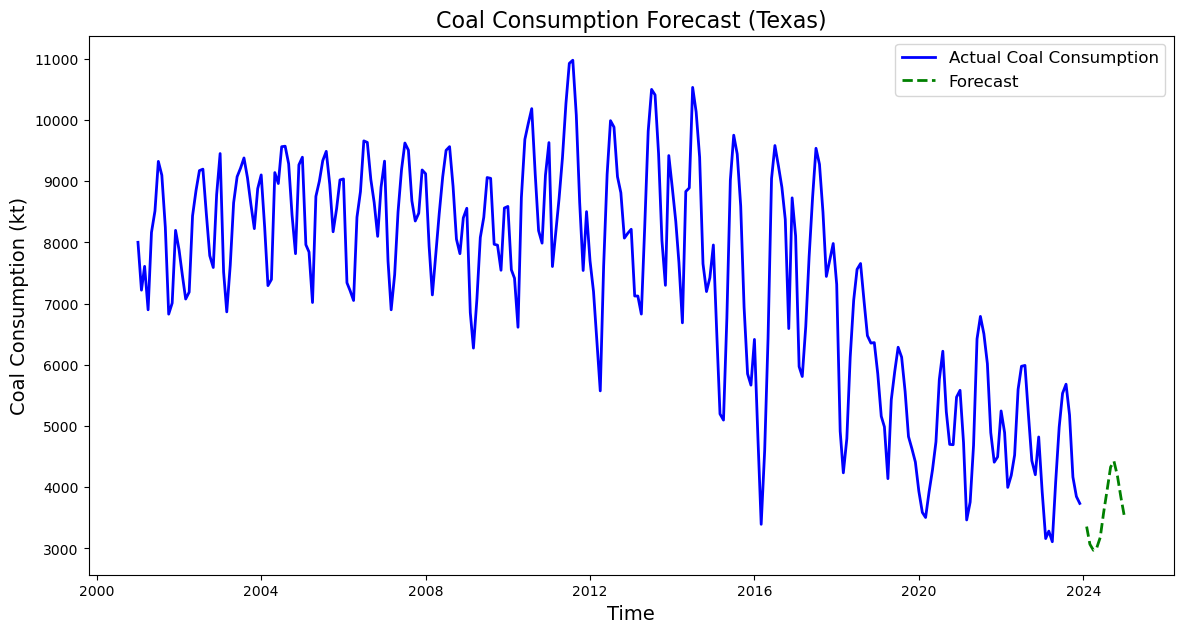

In [171]:
# make future predictions
# use last 15 months
last_sequence = scaled_features[-15:]

# generate predictions for the next 12 months
future_predictions_scaled = []
for _ in range(12):
    # predict the next value using the last sequence
    next_pred = model.predict(last_sequence.reshape(1, 15, len(features)))

    # append the predicted value to the future predictions list
    future_predictions_scaled.append(next_pred[0, 0])

    # create a new sequence with the new prediction appended
    last_sequence = np.vstack([last_sequence[1:], np.hstack([next_pred, np.zeros((1, len(features) - 1))])])

# inverse scale the predictions to the original scale
future_predictions = energy_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# generate the future dates
future_dates = pd.date_range(df_selected.index[-1], periods=13, freq='M')[1:]

# plot the results
plt.figure(figsize=(14, 7))
plt.plot(df_selected.index, df_selected['coal (kt)'], label='Actual Coal Consumption', color='blue', linewidth=2)
plt.plot(future_dates, future_predictions, label='Forecast', color='green', linestyle='--', linewidth=2)
plt.title('Coal Consumption Forecast (Texas)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Coal Consumption (kt)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

##### Model #1 Results:
- Test Loss: 0.012070530094206333
- Mean Absolute Error (MAE): 729.74
- RMSE: 864.43
- R² Score: 0.10
- Mean Absolute Percentage Error (MAPE): 14.86%

### Model #2
#### I'm increasing the sequence length, units, and epochs
- Hyperparameters:
    - sequence length: 30
    - 2 layers
    - 100 units for first two layers
    - 100 epochs

In [123]:
# prepare the feature and target data
X, y = create_sequences(scaled_features, scaled_total_energy.flatten(), seq_length=30)

In [124]:
# split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [125]:
# build the model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=1))

c:\Users\Chris\anaconda3\envs\dev\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [126]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [127]:
# train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.2883 - val_loss: 0.4016
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0416 - val_loss: 0.1044
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0480 - val_loss: 0.2103
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0330 - val_loss: 0.1004
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0317 - val_loss: 0.0923
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0272 - val_loss: 0.0573
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0272 - val_loss: 0.0648
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0251 - val_loss: 0.0627
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0248 - val_loss: 0.0680
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0234 - val_loss: 0.0541
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0228 - val_loss: 0.0452
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0216 - val_l

In [128]:
# evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0202
Test Loss: 0.019290287047624588


In [129]:
# make predictions
y_pred_scaled  = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step


In [130]:
# inverse scaling for predictions
y_pred = energy_scaler.inverse_transform(y_pred_scaled)
# inverse scaling for the actual values
y_test_actual = energy_scaler.inverse_transform(y_test.reshape(-1, 1))

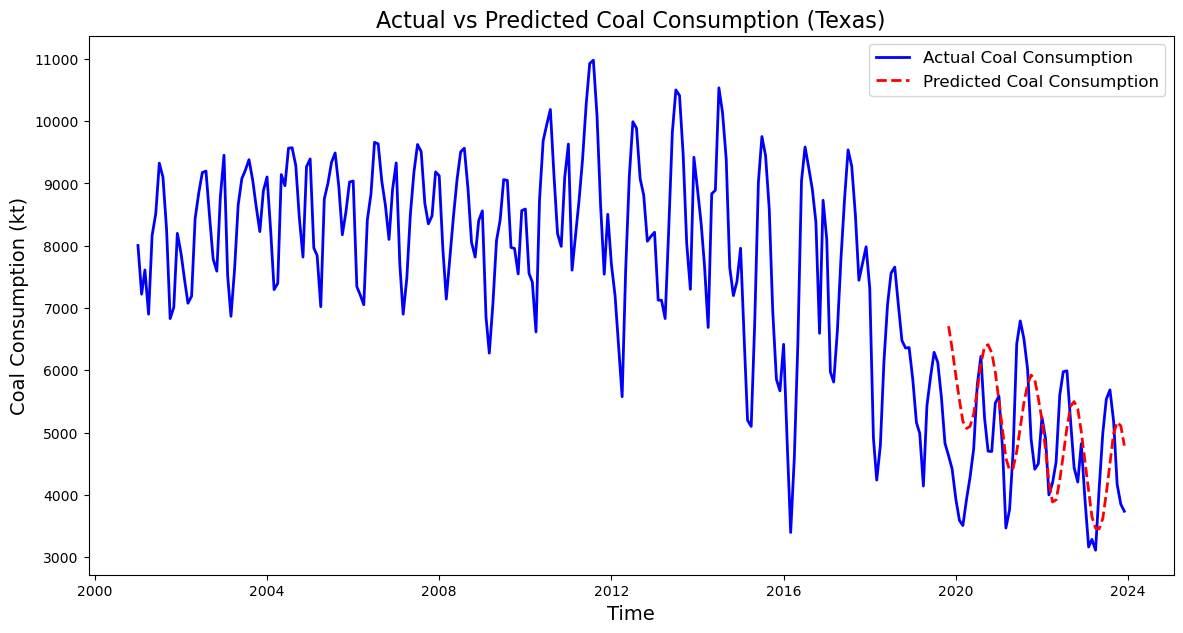

In [131]:
# plot the results
plt.figure(figsize=(14, 7))

# plot the actual data
plt.plot(df_selected.index[-len(y_test_actual)-len(df_selected['coal (kt)'])+1:], 
         np.concatenate((df_selected['coal (kt)'][:-len(y_test_actual)], y_test_actual.flatten())), 
         label='Actual Coal Consumption', color='blue', linewidth=2)

# plot the predicted data
plt.plot(df_selected.index[-len(y_pred):], y_pred, label='Predicted Coal Consumption', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Coal Consumption (Texas)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Coal Consumption (kt)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [132]:
# calculate errors
errors = y_test_actual - y_pred

# calculate various error metrics
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))
r2 = r2_score(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

# print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 919.79
RMSE: 1092.78
R² Score: -0.43
Mean Absolute Percentage Error (MAPE): 20.33%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\Chris\AppData\Local\Temp\ipykernel_15172\3494774975.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(df_selected.index[-1], periods=13, freq='M')[1:]


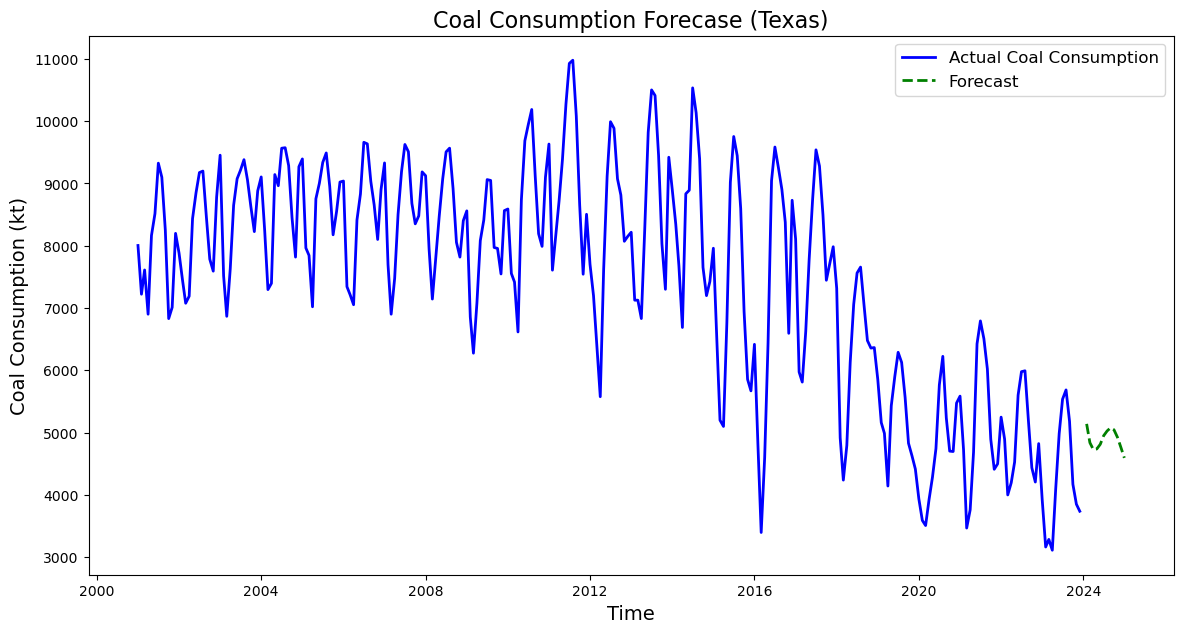

In [133]:
# make future predictions
# use last 15 months
last_sequence = scaled_features[-15:]

# generate predictions for the next 12 months
future_predictions_scaled = []
for _ in range(12):
    # predict the next value using the last sequence
    next_pred = model.predict(last_sequence.reshape(1, 15, len(features)))

    # append the predicted value to the future predictions list
    future_predictions_scaled.append(next_pred[0, 0])

    # create a new sequence with the new prediction appended
    last_sequence = np.vstack([last_sequence[1:], np.hstack([next_pred, np.zeros((1, len(features) - 1))])])

# inverse scale the predictions to the original scale
future_predictions = energy_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# generate the future dates
future_dates = pd.date_range(df_selected.index[-1], periods=13, freq='M')[1:]

# plot the results
plt.figure(figsize=(14, 7))
plt.plot(df_selected.index, df_selected['coal (kt)'], label='Actual Coal Consumption', color='blue', linewidth=2)
plt.plot(future_dates, future_predictions, label='Forecast', color='green', linestyle='--', linewidth=2)
plt.title('Coal Consumption Forecase (Texas)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Coal Consumption (kt)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

#### Model #2 Results:
- Test Loss: 0.05270807445049286
- Mean Absolute Error (MAE): 1576.12
- RMSE: 1806.35
- R² Score: -2.92
- Mean Absolute Percentage Error (MAPE): 37.73%

### Model #3
#### I'm returning the sequence length, units, and epochs back down. I'm adding dropout layers and L2 Regulation
- Hyperparameters:
    - sequence length: 20
    - 2 normal layers, two dropout layers
    - 50 epochs

In [134]:
# prepare the feature and target ddata
X, y = create_sequences(scaled_features, scaled_total_energy.flatten(), seq_length=20)

In [135]:
# split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [136]:
# build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))  
model.add(LSTM(units=50, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2)) 
model.add(Dense(units=1))

c:\Users\Chris\anaconda3\envs\dev\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [137]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [138]:
# train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 1.1114 - val_loss: 1.1647
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8473 - val_loss: 0.8659
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7449 - val_loss: 0.7196
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6696 - val_loss: 0.7201
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5916 - val_loss: 0.6289
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5280 - val_loss: 0.5295
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4725 - val_loss: 0.4947
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4208 - val_loss: 0.4467
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3773 - val_loss: 0.3936
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3363 - val_loss: 0.3651
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3032 - val_loss: 0.3416
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2736 - val_loss: 0.3034


In [139]:
# evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0423 
Test Loss: 0.04146498814225197


In [140]:
# make predictions
y_pred_scaled  = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step


In [141]:
# inverse scaling for predictions
y_pred = energy_scaler.inverse_transform(y_pred_scaled)
# inverse scaling for the actual values
y_test_actual = energy_scaler.inverse_transform(y_test.reshape(-1, 1))

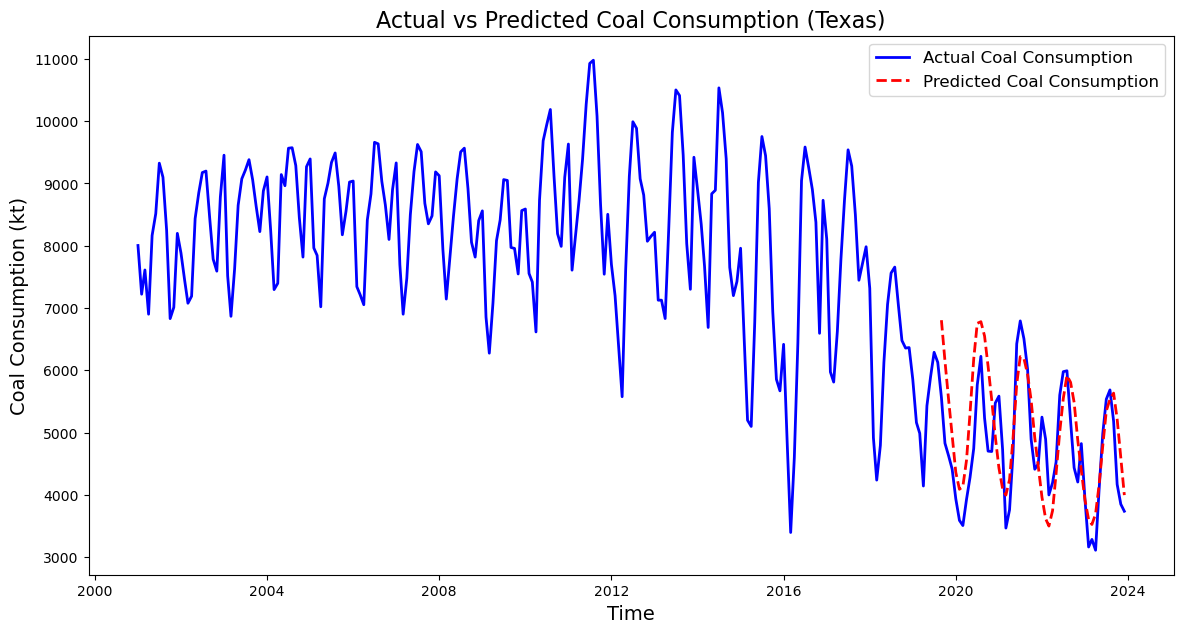

In [142]:
# plot the results
plt.figure(figsize=(14, 7))

# plot the actual data
plt.plot(df_selected.index[-len(y_test_actual)-len(df_selected['coal (kt)'])+1:], 
         np.concatenate((df_selected['coal (kt)'][:-len(y_test_actual)], y_test_actual.flatten())), 
         label='Actual Coal Consumption', color='blue', linewidth=2)

# plot the predicted data
plt.plot(df_selected.index[-len(y_pred):], y_pred, label='Predicted Coal Consumption', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Coal Consumption (Texas)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Coal Consumption (kt)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [143]:
# calculate errors
errors = y_test_actual - y_pred

# calculate various error metrics
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))
r2 = r2_score(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

# print metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 615.94
RMSE: 726.68
R² Score: 0.35
Mean Absolute Percentage Error (MAPE): 13.25%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\Chris\AppData\Local\Temp\ipykernel_15172\3494774975.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(df_selected.index[-1], periods=13, freq='M')[1:]


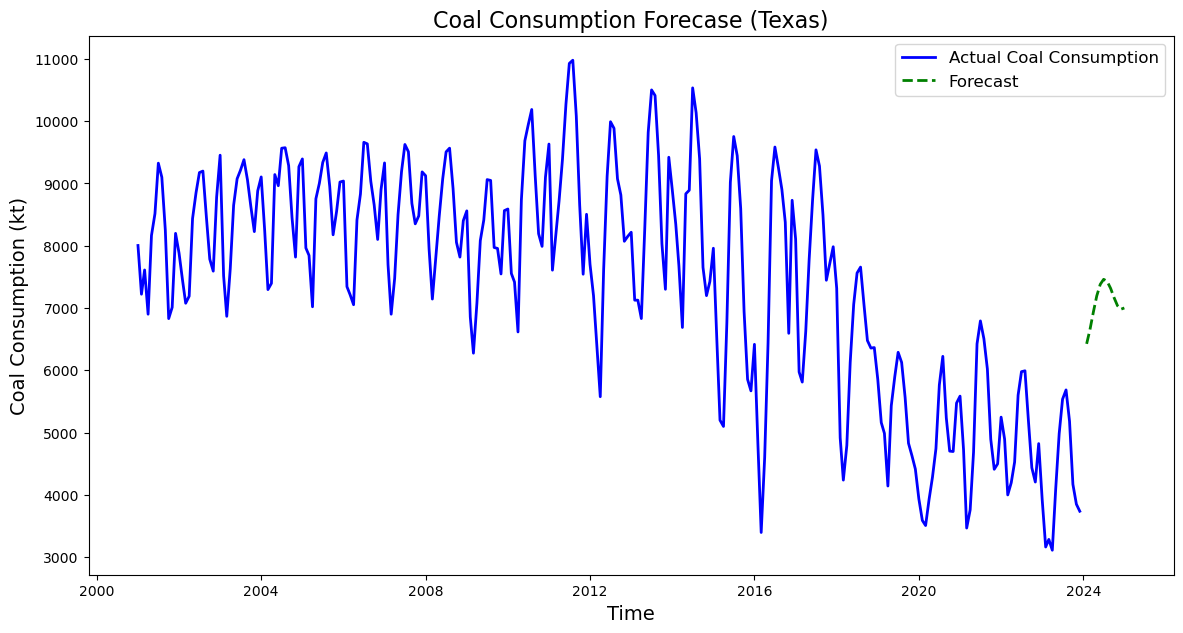

In [144]:
# make future predictions
# use last 15 months
last_sequence = scaled_features[-15:]

# generate predictions for the next 12 months
future_predictions_scaled = []
for _ in range(12):
    # predict the next value using the last sequence
    next_pred = model.predict(last_sequence.reshape(1, 15, len(features)))

    # append the predicted value to the future predictions list
    future_predictions_scaled.append(next_pred[0, 0])

    # create a new sequence with the new prediction appended
    last_sequence = np.vstack([last_sequence[1:], np.hstack([next_pred, np.zeros((1, len(features) - 1))])])

# inverse scale the predictions to the original scale
future_predictions = energy_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# generate the future dates
future_dates = pd.date_range(df_selected.index[-1], periods=13, freq='M')[1:]

# plot the results
plt.figure(figsize=(14, 7))
plt.plot(df_selected.index, df_selected['coal (kt)'], label='Actual Coal Consumption', color='blue', linewidth=2)
plt.plot(future_dates, future_predictions, label='Forecast', color='green', linestyle='--', linewidth=2)
plt.title('Coal Consumption Forecase (Texas)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Coal Consumption (kt)', fontsize=14)
plt.legend(fontsize=12)
plt.show()

#### Model #3 Results:
- Test Loss: 0.038526520133018494
- Mean Absolute Error (MAE): 1022.49
- RMSE: 1195.33
- R² Score: -0.75
- Mean Absolute Percentage Error (MAPE): 24.56%

# Summary
## The first model easily had the best results and accurate predictions